In [1]:
# change directory location if needed:    
data_dir = "/scratch/new_courier_pilot/" ## pilot data directory
# data_dir = "/scratch/EFRCourier_reports/" ## hospital data directory
time_window=10000 # you can chose how long do you want to visualize the data
exp = 'EFRCourierOpenLoop'
subject = 'R1620J' 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import glob
import cmlreaders as cml
import json
from matplotlib.ticker import FuncFormatter
import warnings
import numpy as np
import pandas as pd

# Get the full data index
whole_df = cml.CMLReader.get_data_index()

# Define the experiment
exp = 'EFRCourierOpenLoop'

# Get unique subjects for the experiment
subjects = whole_df.query('experiment == @exp')['subject'].unique()

# Initialize results storage
results = []

# Loop through each subject
for subject in subjects:
    print(f"Processing subject: {subject}")
    
    # Get subject data
    sub_df = whole_df.query('experiment == @exp and subject == @subject')
    
    # Get all sessions for this subject
    sessions = sub_df['session'].unique()
    
    # Loop through each session
    for session in sessions:
        print(f"  Processing session: {session}")
        
        try:
            # Create reader for this subject and session
            reader = cml.CMLReader(subject, exp, session=session)
            evs = reader.load('task_events')
            
            # Add the inside_stimuli variable
            evs['inside_stimuli'] = -999
            stimuli_indices = evs[evs['type'] == 'STIM'].index
            for i in stimuli_indices:
                current_offset = evs.loc[i, 'eegoffset']
                
                # Keep checking subsequent rows until difference >= 3000
                j = i + 1
                rows_to_assign = []  # Store indices of rows to assign
                
                while j < len(evs):
                    next_offset = evs.loc[j, 'eegoffset']
                    time_diff = abs(next_offset - current_offset)
                    
                    if time_diff < 3000:
                        # Still within 3 seconds, add this row to assignment list
                        rows_to_assign.append(j)
                        j += 1
                    else:
                        # Found a row with difference >= 4000, stop checking
                        break
                
                # Assign burst_freq to all rows that were within 4000ms of the STIM
                for row_idx in rows_to_assign:
                    evs.loc[row_idx, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
            
            # Filter for intrusions (intrusion == 1)
            
            evs = add_phase(evs)
            intrusion_events = evs[(evs['intrusion'] > 0) | (evs['intrusion'] == -1)]
            none_intrusion_events = evs[evs['intrusion'] == 0]

                # Count intrusions for each stimulation condition
            intrusion_count_3hz = (intrusion_events['inside_stimuli'] == 3).sum()
            intrusion_count_8hz = (intrusion_events['inside_stimuli'] == 8).sum()
            intrusion_count_no_stim = (intrusion_events['inside_stimuli'] == -999).sum()
            intrusion_count_total = len(intrusion_events)

                # Count none intrusions for each stimulation condition
            none_intrusion_count_3hz = (none_intrusion_events['inside_stimuli'] == 3).sum()
            none_intrusion_count_8hz = (none_intrusion_events['inside_stimuli'] == 8).sum()
            none_intrusion_count_no_stim = (none_intrusion_events['inside_stimuli'] == -999).sum()
            none_intrusion_count_total = len(none_intrusion_events)

                # Store results
            
            session_result = {
                        'subject': subject,
                        'session': session,
                        'intrusion_count_3hz': intrusion_count_3hz,
                        'intrusion_count_8hz': intrusion_count_8hz,
                        'intrusion_count_no_stim': intrusion_count_no_stim,
                        'intrusion_count_total': intrusion_count_total,
                        'none_intrusion_count_3hz': none_intrusion_count_3hz,
                        'none_intrusion_count_8hz': none_intrusion_count_8hz,
                        'none_intrusion_count_no_stim': none_intrusion_count_no_stim,
                        'none_intrusion_count_total': none_intrusion_count_total,
                        'relative_rate_3hz': intrusion_count_3hz / none_intrusion_count_3hz if none_intrusion_count_3hz != 0 else None,
                        'relative_rate_8hz': intrusion_count_8hz / none_intrusion_count_8hz if none_intrusion_count_8hz != 0 else None,
                        'relative_rate_no_stim': intrusion_count_no_stim / none_intrusion_count_no_stim if none_intrusion_count_no_stim != 0 else None
                }
            results.append(session_result)
            
            print(f"    Intrusions - 3Hz: {intrusion_count_3hz}, 8Hz: {intrusion_count_8hz}, No stim: {intrusion_count_no_stim}, Total: {intrusion_count_total}")
            
        except Exception as e:
            print(f"    Error processing session {session}: {str(e)}")
            continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display summary statistics
print("\n" + "="*50)
print("INTRUSION ANALYSIS SUMMARY")
print("="*50)

if len(results_df) > 0:
    print(f"Total subjects processed: {results_df['subject'].nunique()}")
    print(f"Total sessions processed: {len(results_df)}")
    print(f"\nIntrusion statistics across all sessions:")
    print(f"Mean intrusions per session:")
    print(f"  3Hz stimulation: {results_df['intrusion_count_3hz'].mean():.3f} ± {results_df['intrusion_count_3hz'].std():.3f}")
    print(f"  8Hz stimulation: {results_df['intrusion_count_8hz'].mean():.3f} ± {results_df['intrusion_count_8hz'].std():.3f}")
    print(f"  No stimulation: {results_df['intrusion_count_no_stim'].mean():.3f} ± {results_df['intrusion_count_no_stim'].std():.3f}")
    print(f"  Total: {results_df['intrusion_count_total'].mean():.3f} ± {results_df['intrusion_count_total'].std():.3f}")
    print(f"\nTotal intrusions across all sessions:")
    print(f"  3Hz stimulation: {results_df['intrusion_count_3hz'].sum()}")
    print(f"  8Hz stimulation: {results_df['intrusion_count_8hz'].sum()}")
    print(f"  No stimulation: {results_df['intrusion_count_no_stim'].sum()}")
    print(f"  Total: {results_df['intrusion_count_total'].sum()}")
    
    # Display the results DataFrame
    print(f"\nDetailed results:")
    print(results_df.to_string(index=False))
else:
    print("No results to display. Check for errors in processing.")
   

Processing subject: FBG490
  Processing session: 0
    Error processing session 0: name 'add_phase' is not defined
  Processing session: 1
    Error processing session 1: name 'add_phase' is not defined
  Processing session: 2
    Error processing session 2: name 'add_phase' is not defined
Processing subject: FBG491
  Processing session: 1
    Error processing session 1: name 'add_phase' is not defined
  Processing session: 2
    Error processing session 2: name 'add_phase' is not defined
Processing subject: FR491
  Processing session: 1
    Error processing session 1: Unable to find the requested file in any of the expected locations:
 /protocols/pyfr/subjects/FR491/experiments/EFRCourierOpenLoop/sessions/1/behavioral/current_processed/task_events.json
/data/events/pyFR/FR491_None_events.mat
  Processing session: 2
    Error processing session 2: Unable to find the requested file in any of the expected locations:
 /protocols/pyfr/subjects/FR491/experiments/EFRCourierOpenLoop/sessions/

In [2]:
evs[evs['type']=='REC_START']
evs['trial'].unique()

array([-999,   -1,    0,    1,    2,    3])

In [3]:
intrusion_events[['intruded','intrusion','inside']]

NameError: name 'intrusion_events' is not defined

In [ ]:
evs["type"].unique()

In [4]:
evs["phase"]=1
new_evs = pd.DataFrame()  # Initialize as DataFrame, not list
for ind, list_evs in evs.groupby('trial'):  # 'trial' is the equivalent of a delivery day
    list_evs = list_evs.copy()  # Avoid SettingWithCopyWarning
    if list_evs['trial'].unique()[0] != -999:
        list_evs['phase'] = 'nan'
        if not list_evs[list_evs['type'] == 'TRIAL_START'].index.empty and not list_evs[list_evs['type'] == 'TRIAL_END'].index.empty:
            # find indexes of encoding start and end
            rec_start_indices = list_evs[list_evs['type'] == 'REC_START'].index
            if not rec_start_indices.empty:
                rec_start_index = rec_start_indices[0]
                start_time = list_evs.loc[rec_start_index]['eegoffset']
                # Find the actual start index based on time condition
                i = 0
                rec_start_index_found = True
                actual_start_index = rec_start_index  # Initialize with default
                
                while rec_start_index_found:
                    current_idx = rec_start_index + i
                    print(i)
                    # Check bounds for iloc access
                    check_time = evs.iloc[current_idx]['eegoffset']  # Use relative index i
                    if check_time - start_time < 3000:
                        i += 1
                        print(check_time - start_time)
                    else:
                        rec_start_index_found = False
                        actual_start_index = rec_start_index+i
                        print(i)# Get actual index from list_evs
                rec_end_indices = list_evs[list_evs['type'] == 'REC_STOP'].index
                if not rec_end_indices.empty:
                    rec_end_index = rec_end_indices[0]
                    # Now assign to original evs DataFrame using the original indices
                    evs.loc[actual_start_index:rec_end_index, 'phase'] = 'retrieval'
                    print('get one value', actual_start_index,rec_end_index)


0
0
1
387
2
2434
3
2805
4
4
get one value 110 140
0
0
1
540
2
1540
3
2523
4
2797
5
5
get one value 200 219
0
0
1
257
2
967
3
1902
4
2804
5
2902
6
6
get one value 276 296
0
0
1
142
2
1082
3
2507
4
2797
5
5
get one value 353 379


In [ ]:
check_time = evs.iloc[current_idx]['eegoffset']

In [ ]:
current_idx


In [ ]:
rec_start_indices = list_evs[list_evs['type'] == 'REC_START'].index
rec_start_indices

In [5]:

pd.set_option('display.max_rows', None)
evs[['phase','type']]

,phase,type
0,1,START
1,1,store mappings
2,1,TL_START
3,1,pointing begins
4,1,pointing finished
5,1,pointing begins
6,1,pointing finished
7,1,POINTER_ON
8,1,pointing begins
9,1,pointing finished


In [ ]:
list_evs[list_evs['type'] == 'REC_START']

In [ ]:
list_evs.loc[start_index]

In [ ]:
actual_start_index

In [ ]:
rec_start_index = list_evs[list_evs['type']=='REC_START'].index[0]
rec_end_index = list_evs[list_evs['type']=='REC_STOP'].index[0]
list_evs.loc[rec_start_index:]['phase'] = 'retrieval'

In [ ]:
list_evs.loc[301]

In [ ]:
# change directory location if needed:    
data_dir = "/scratch/new_courier_pilot/" ## pilot data directory
# data_dir = "/scratch/EFRCourier_reports/" ## hospital data directory
time_window=10000 # you can chose how long do you want to visualize the data
exp = 'EFRCourierOpenLoop'
subject = 'R1620J' 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import glob
import cmlreaders as cml
import json
from matplotlib.ticker import FuncFormatter
import warnings
import numpy as np
import pandas as pd

# Get the full data index
whole_df = cml.CMLReader.get_data_index()

# Define the experiment
exp = 'EFRCourierOpenLoop'

# Get unique subjects for the experiment
subjects = whole_df.query('experiment == @exp')['subject'].unique()

# Initialize results storage
results = []

# Loop through each subject
for subject in subjects:
    print(f"Processing subject: {subject}")
    
    # Get subject data
    sub_df = whole_df.query('experiment == @exp and subject == @subject')
    
    # Get all sessions for this subject
    sessions = sub_df['session'].unique()
    
    # Loop through each session
    for session in sessions:
        print(f"  Processing session: {session}")
        
        try:
            # Create reader for this subject and session
            reader = cml.CMLReader(subject, exp, session=session)
            evs = reader.load('task_events')
          

In [ ]:
evs['phase']=1

In [18]:
# change directory location if needed:    
data_dir = "/scratch/new_courier_pilot/" ## pilot data directory
# data_dir = "/scratch/EFRCourier_reports/" ## hospital data directory
time_window=10000 # you can chose how long do you want to visualize the data
exp = 'EFRCourierOpenLoop'
subject = 'R1620J' 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import glob
import cmlreaders as cml
import json
from matplotlib.ticker import FuncFormatter
import warnings
import numpy as np
import pandas as pd

def add_phase_column(evs):
    """Add phase column to events DataFrame"""
    evs["phase"] = 1
    new_evs = pd.DataFrame()  # Initialize as DataFrame, not list
    for ind, list_evs in evs.groupby('trial'):  # 'trial' is the equivalent of a delivery day
        list_evs = list_evs.copy()  # Avoid SettingWithCopyWarning
        if list_evs['trial'].unique()[0] != -999:
            list_evs['phase'] = 'nan'
            if not list_evs[list_evs['type'] == 'TRIAL_START'].index.empty and not list_evs[list_evs['type'] == 'TRIAL_END'].index.empty:
                # find indexes of encoding start and end
                rec_start_indices = list_evs[list_evs['type'] == 'REC_START'].index
                if not rec_start_indices.empty:
                    rec_start_index = rec_start_indices[0]
                    start_time = list_evs.loc[rec_start_index]['eegoffset']
                    # Find the actual start index based on time condition
                    i = 0
                    rec_start_index_found = True
                    actual_start_index = rec_start_index  # Initialize with default
                    
                    while rec_start_index_found:
                        current_idx = rec_start_index + i
                        print(i)
                        # Check bounds for iloc access
                        check_time = evs.iloc[current_idx]['eegoffset']  # Use relative index i
                        if check_time - start_time < 3000:
                            i += 1
                            print(check_time - start_time)
                        else:
                            rec_start_index_found = False
                            actual_start_index = rec_start_index+i
                            print(i)# Get actual index from list_evs
                    rec_end_indices = list_evs[list_evs['type'] == 'REC_STOP'].index
                    if not rec_end_indices.empty:
                        rec_end_index = rec_end_indices[0]
                        # Now assign to original evs DataFrame using the original indices
                        evs.loc[actual_start_index:rec_end_index, 'phase'] = 'retrieval'
                        print('get one value', actual_start_index,rec_end_index)
    return evs

# Get the full data index
whole_df = cml.CMLReader.get_data_index()

# Define the experiment
exp = 'EFRCourierOpenLoop'

# Get unique subjects for the experiment
subjects = whole_df.query('experiment == @exp')['subject'].unique()

# Initialize results storage
results = []

# Loop through each subject
for subject in subjects:
    print(f"Processing subject: {subject}")
    
    # Get subject data
    sub_df = whole_df.query('experiment == @exp and subject == @subject')
    
    # Get all sessions for this subject
    sessions = sub_df['session'].unique()
    
    # Loop through each session
    for session in sessions:
        print(f"  Processing session: {session}")
        
        try:
            # Create reader for this subject and session
            reader = cml.CMLReader(subject, exp, session=session)
            evs = reader.load('task_events')
            
            # Add the phase column
            evs = add_phase_column(evs)
            
            # Add the inside_stimuli variable
            evs['inside_stimuli'] = -999
            stimuli_indices = evs[evs['type'] == 'STIM'].index
            for i in stimuli_indices:
                current_offset = evs.loc[i, 'eegoffset']
                
                # Keep checking subsequent rows until difference >= 3000
                j = i + 1
                rows_to_assign = []  # Store indices of rows to assign
                
                while j < len(evs):
                    next_offset = evs.loc[j, 'eegoffset']
                    time_diff = abs(next_offset - current_offset)
                    
                    if time_diff < 3000:
                        # Still within 3 seconds, add this row to assignment list
                        rows_to_assign.append(j)
                        j += 1
                    else:
                        # Found a row with difference >= 4000, stop checking
                        break
                
                # Assign burst_freq to all rows that were within 4000ms of the STIM
                for row_idx in rows_to_assign:
                    evs.loc[row_idx, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
            
            # Get unique trials for this session
            trials = evs['trial'].unique()
            
            # Loop through each trial
            for trial in trials:
                if trial != -999 and trial >= 0:  # Skip invalid trials   if trial != -999 and trial >= 0:
                    print(f"    Processing trial: {trial}")
                    
                    # Filter events for this specific trial
                    trial_evs = evs[evs['trial'] == trial]
                    
                    # Filter for intrusions with additional conditions for this trial
                    intrusion_events = trial_evs[((trial_evs['intrusion'] > 0) | (trial_evs['intrusion'] == -1)) & 
                                                (trial_evs['type'] == 'REC_WORD') & 
                                                (trial_evs['phase'] == 'retrieval')]
                    none_intrusion_events = trial_evs[(trial_evs['intrusion'] == 0) & 
                                                     (trial_evs['type'] == 'REC_WORD') & 
                                                     (trial_evs['phase'] == 'retrieval')]

                    # Count intrusions for each stimulation condition
                    intrusion_count_3hz = (intrusion_events['inside_stimuli'] == 3).sum()
                    intrusion_count_8hz = (intrusion_events['inside_stimuli'] == 8).sum()
                    intrusion_count_no_stim = (intrusion_events['inside_stimuli'] == -999).sum()
                    intrusion_count_total = len(intrusion_events)

                    # Count none intrusions for each stimulation condition
                    none_intrusion_count_3hz = (none_intrusion_events['inside_stimuli'] == 3).sum()
                    none_intrusion_count_8hz = (none_intrusion_events['inside_stimuli'] == 8).sum()
                    none_intrusion_count_no_stim = (none_intrusion_events['inside_stimuli'] == -999).sum()
                    none_intrusion_count_total = len(none_intrusion_events)

                    # Store results for this trial
                    trial_result = {
                                'subject': subject,
                                'session': session,
                                'trial': trial,
                                'intrusion_count_3hz': intrusion_count_3hz if  (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'intrusion_count_8hz': intrusion_count_8hz if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'intrusion_count_no_stim': intrusion_count_no_stim,
                                'intrusion_count_total': intrusion_count_total,
                                'none_intrusion_count_3hz': none_intrusion_count_3hz if  (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'none_intrusion_count_8hz': none_intrusion_count_8hz if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'none_intrusion_count_no_stim': none_intrusion_count_no_stim,
                                'none_intrusion_count_total': none_intrusion_count_total,
                                'relative_intrusion_3hz': intrusion_count_3hz - intrusion_count_no_stim if intrusion_count_3hz != 0 else None, 
                                'relative_intrusion_8hz': intrusion_count_8hz - intrusion_count_no_stim if intrusion_count_8hz != 0 else None,
                                'relative_recall_3hz': none_intrusion_count_3hz - none_intrusion_count_no_stim if none_intrusion_count_3hz != 0 else None,
                                'relative_recall_8hz': none_intrusion_count_8hz - none_intrusion_count_no_stim if none_intrusion_count_8hz != 0 else None,
                            }
                    results.append(trial_result)
                    
                    print(f"      Trial {trial} - Intrusions - 3Hz: {intrusion_count_3hz}, 8Hz: {intrusion_count_8hz}, No stim: {intrusion_count_no_stim}, Total: {intrusion_count_total}")
            
        except Exception as e:
            print(f"    Error processing session {session}: {str(e)}")
            continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display summary statistics
print("\n" + "="*50)
print("INTRUSION ANALYSIS SUMMARY (BY TRIAL)")
print("="*50)

if len(results_df) > 0:
    print(f"Total subjects processed: {results_df['subject'].nunique()}")
    print(f"Total sessions processed: {results_df['session'].nunique()}")
    print(f"Total trials processed: {len(results_df)}")
    print(f"\nIntrusion statistics across all trials:")
    print(f"Mean intrusions per trial:")
    print(f"  3Hz stimulation: {results_df['intrusion_count_3hz'].mean():.3f} ± {results_df['intrusion_count_3hz'].std():.3f}")
    print(f"  8Hz stimulation: {results_df['intrusion_count_8hz'].mean():.3f} ± {results_df['intrusion_count_8hz'].std():.3f}")
    print(f"  No stimulation: {results_df['intrusion_count_no_stim'].mean():.3f} ± {results_df['intrusion_count_no_stim'].std():.3f}")
    print(f"  Total: {results_df['intrusion_count_total'].mean():.3f} ± {results_df['intrusion_count_total'].std():.3f}")
    print(f"\nTotal intrusions across all trials:")
    print(f"  3Hz stimulation: {results_df['intrusion_count_3hz'].sum()}")
    print(f"  8Hz stimulation: {results_df['intrusion_count_8hz'].sum()}")
    print(f"  No stimulation: {results_df['intrusion_count_no_stim'].sum()}")
    print(f"  Total: {results_df['intrusion_count_total'].sum()}")
    
    # Display the results DataFrame
    print(f"\nDetailed results:")
    print(results_df.to_string(index=False))
else:
    print("No results to display. Check for errors in processing.")

Processing subject: FBG490
  Processing session: 0
0
0
1
1
get one value 49 67
0
0
1
1
get one value 155 177
0
0
1
1
get one value 264 282
0
0
1
1
get one value 370 389
0
0
1
1
get one value 474 492
    Processing trial: 0
      Trial 0 - Intrusions - 3Hz: 0, 8Hz: 0, No stim: 2, Total: 2
    Processing trial: 1
      Trial 1 - Intrusions - 3Hz: 0, 8Hz: 0, No stim: 0, Total: 0
    Processing trial: 2
      Trial 2 - Intrusions - 3Hz: 0, 8Hz: 0, No stim: 2, Total: 2
    Processing trial: 3
      Trial 3 - Intrusions - 3Hz: 0, 8Hz: 0, No stim: 0, Total: 0
    Processing trial: 4
      Trial 4 - Intrusions - 3Hz: 0, 8Hz: 1, No stim: 1, Total: 2
  Processing session: 1
0
0
1
1
get one value 48 78
0
0
1
1
get one value 164 189
0
0
1
1
get one value 278 299
0
0
1
1
get one value 389 409
0
0
1
1
get one value 496 522
    Processing trial: 0
      Trial 0 - Intrusions - 3Hz: 0, 8Hz: 0, No stim: 2, Total: 2
    Processing trial: 1
      Trial 1 - Intrusions - 3Hz: 0, 8Hz: 0, No stim: 1, Total: 1

In [19]:
results_df

,subject,session,trial,intrusion_count_3hz,intrusion_count_8hz,intrusion_count_no_stim,intrusion_count_total,none_intrusion_count_3hz,none_intrusion_count_8hz,none_intrusion_count_no_stim,none_intrusion_count_total,relative_intrusion_3hz,relative_intrusion_8hz,relative_recall_3hz,relative_recall_8hz
0,FBG490,0,0,NaN,0.0,2,2,NaN,1.0,4,5,NaN,NaN,NaN,-3.0
1,FBG490,0,1,0.0,NaN,0,0,1.0,NaN,7,8,NaN,NaN,-6.0,NaN
2,FBG490,0,2,NaN,0.0,2,2,NaN,2.0,5,7,NaN,NaN,NaN,-3.0
3,FBG490,0,3,0.0,NaN,0,0,2.0,NaN,9,11,NaN,NaN,-7.0,NaN
4,FBG490,0,4,NaN,1.0,1,2,NaN,1.0,6,7,NaN,0.0,NaN,-5.0
5,FBG490,1,0,NaN,0.0,2,2,NaN,2.0,7,9,NaN,NaN,NaN,-5.0
6,FBG490,1,1,0.0,NaN,1,1,1.0,NaN,10,11,NaN,NaN,-9.0,NaN
7,FBG490,1,2,NaN,1.0,0,1,NaN,1.0,7,8,NaN,1.0,NaN,-6.0
8,FBG490,1,3,0.0,NaN,1,1,2.0,NaN,5,7,NaN,NaN,-3.0,NaN
9,FBG490,1,4,NaN,0.0,4,4,NaN,2.0,6,8,NaN,NaN,NaN,-4.0



CHANGE vs NO STIMULATION BASELINE
INTRUSION CHANGES:
  3Hz vs No Stim: -0.18
  8Hz vs No Stim: -0.39

CORRECT RECALL CHANGES:
  3Hz vs No Stim: -1.14
  8Hz vs No Stim: -1.52

Plot saved as: efr_courier_simple_analysis.png
Results saved as: efr_courier_results.csv


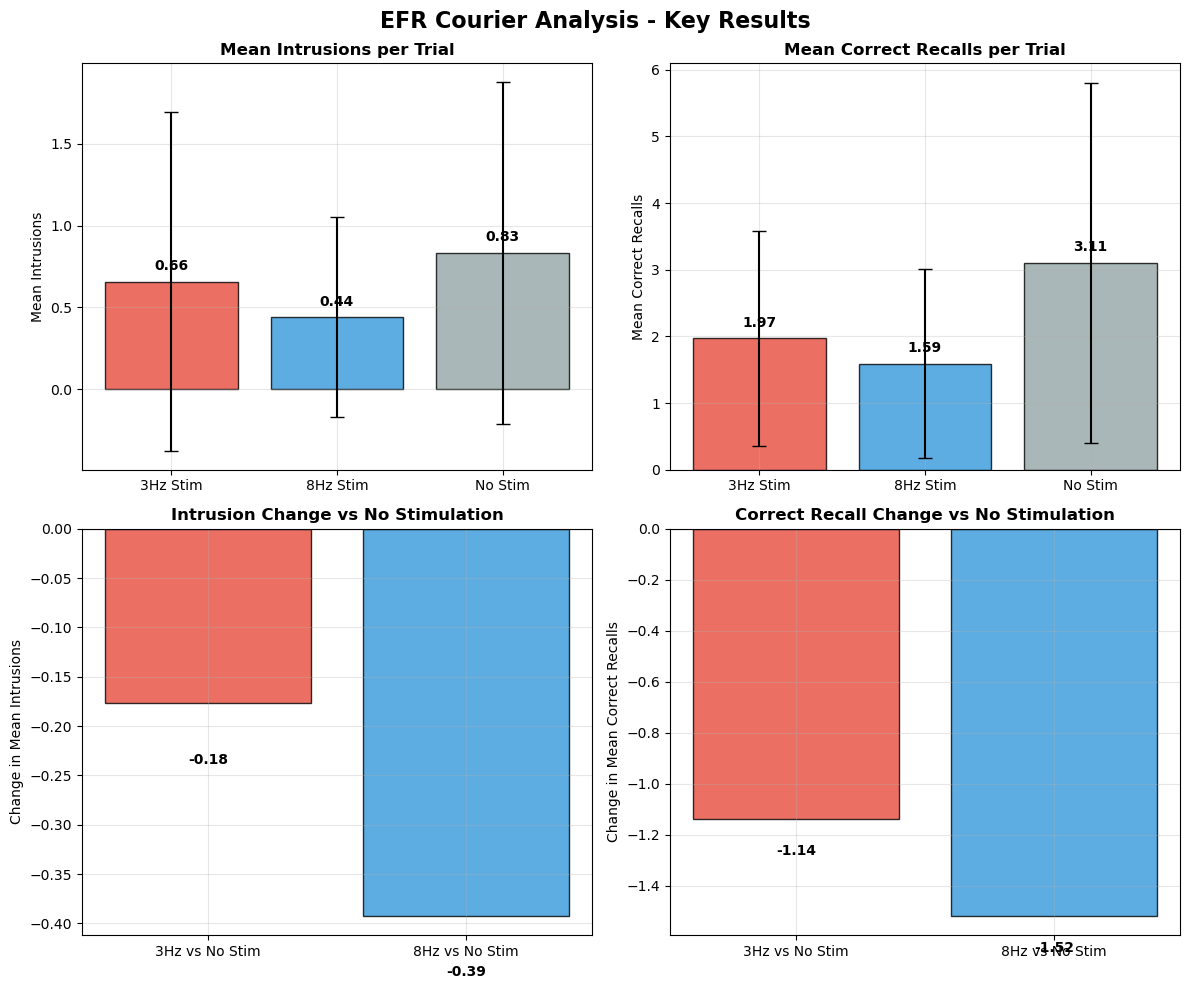


Analysis complete!


In [25]:
# Set up the figure
intrusion_3hz_mean = results_df['intrusion_count_3hz'].dropna().mean()
intrusion_3hz_std = results_df['intrusion_count_3hz'].dropna().std()
intrusion_8hz_mean = results_df['intrusion_count_8hz'].dropna().mean()
intrusion_8hz_std = results_df['intrusion_count_8hz'].dropna().std()
intrusion_no_stim_mean = results_df['intrusion_count_no_stim'].mean()
intrusion_no_stim_std = results_df['intrusion_count_no_stim'].std()

recall_3hz_mean = results_df['none_intrusion_count_3hz'].dropna().mean()
recall_3hz_std = results_df['none_intrusion_count_3hz'].dropna().std()
recall_8hz_mean = results_df['none_intrusion_count_8hz'].dropna().mean()
recall_8hz_std = results_df['none_intrusion_count_8hz'].dropna().std()
recall_no_stim_mean = results_df['none_intrusion_count_no_stim'].mean()
recall_no_stim_std = results_df['none_intrusion_count_no_stim'].std()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('EFR Courier Analysis - Key Results', fontsize=16, fontweight='bold')

# Colors for conditions
colors = ['#e74c3c', '#3498db', '#95a5a6']  # Red, Blue, Gray
condition_labels = ['3Hz Stim', '8Hz Stim', 'No Stim']

# Plot 1: Mean Intrusions per Trial
intrusion_means = [intrusion_3hz_mean, intrusion_8hz_mean, intrusion_no_stim_mean]
intrusion_stds = [intrusion_3hz_std, intrusion_8hz_std, intrusion_no_stim_std]

bars1 = ax1.bar(condition_labels, intrusion_means, yerr=intrusion_stds, 
                capsize=5, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Mean Intrusions per Trial', fontweight='bold')
ax1.set_ylabel('Mean Intrusions')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean in zip(bars1, intrusion_means):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(intrusion_stds)/20,
             f'{mean:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Mean Correct Recalls per Trial
recall_means = [recall_3hz_mean, recall_8hz_mean, recall_no_stim_mean]
recall_stds = [recall_3hz_std, recall_8hz_std, recall_no_stim_std]

bars2 = ax2.bar(condition_labels, recall_means, yerr=recall_stds,
                capsize=5, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_title('Mean Correct Recalls per Trial', fontweight='bold')
ax2.set_ylabel('Mean Correct Recalls')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean in zip(bars2, recall_means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(recall_stds)/20,
             f'{mean:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Change in Intrusions vs No Stimulation Baseline
intrusion_change_3hz = intrusion_3hz_mean - intrusion_no_stim_mean
intrusion_change_8hz = intrusion_8hz_mean - intrusion_no_stim_mean
intrusion_changes = [intrusion_change_3hz, intrusion_change_8hz]
change_labels = ['3Hz vs No Stim', '8Hz vs No Stim']

bars3 = ax3.bar(change_labels, intrusion_changes, color=[colors[0], colors[1]], 
                alpha=0.8, edgecolor='black', linewidth=1)
ax3.set_title('Intrusion Change vs No Stimulation', fontweight='bold')
ax3.set_ylabel('Change in Mean Intrusions')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add value labels on bars
for bar, change in zip(bars3, intrusion_changes):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, 
             height + 0.05 if height >= 0 else height - 0.05,
             f'{change:.2f}', ha='center', 
             va='bottom' if height >= 0 else 'top', fontweight='bold')

# Plot 4: Change in Correct Recalls vs No Stimulation Baseline
recall_change_3hz = recall_3hz_mean - recall_no_stim_mean
recall_change_8hz = recall_8hz_mean - recall_no_stim_mean
recall_changes = [recall_change_3hz, recall_change_8hz]

bars4 = ax4.bar(change_labels, recall_changes, color=[colors[0], colors[1]], 
                alpha=0.8, edgecolor='black', linewidth=1)
ax4.set_title('Correct Recall Change vs No Stimulation', fontweight='bold')
ax4.set_ylabel('Change in Mean Correct Recalls')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add value labels on bars
for bar, change in zip(bars4, recall_changes):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2,
             height + 0.1 if height >= 0 else height - 0.1,
             f'{change:.2f}', ha='center',
             va='bottom' if height >= 0 else 'top', fontweight='bold')

# Adjust layout and show
plt.tight_layout()

# Print change statistics
print("\n" + "="*50)
print("CHANGE vs NO STIMULATION BASELINE")
print("="*50)
print("INTRUSION CHANGES:")
print(f"  3Hz vs No Stim: {intrusion_change_3hz:.2f}")
print(f"  8Hz vs No Stim: {intrusion_change_8hz:.2f}")
print()
print("CORRECT RECALL CHANGES:")
print(f"  3Hz vs No Stim: {recall_change_3hz:.2f}")
print(f"  8Hz vs No Stim: {recall_change_8hz:.2f}")

# Save the plot
plt.savefig('efr_courier_simple_analysis.png', dpi=300, bbox_inches='tight')
print(f"\nPlot saved as: efr_courier_simple_analysis.png")

# Save results to CSV
results_df.to_csv('efr_courier_results.csv', index=False)
print(f"Results saved as: efr_courier_results.csv")

plt.show()

print("\nAnalysis complete!")